Sample code for reproducing Fig.1C-E:
1.  we use a binary search in $k_1$ to find $k_1^\star$ that balances the mean dwell times of the two states
2.  we run a long trajectory to compute the distribution of dwell time and switching time (Fig. 1D-E)
3.  we demonstrate how tuning $\Delta E_B$ (effective kinetic barrier that is affected by both ligand binding and receptor methylation) modulates the mean activity $\langle a\rangle$ (Fig. 1C)

In [42]:
from jax import config

config.update("jax_enable_x64", True)
import jax.numpy as np
from jax import lax
import numpy as onp
import matplotlib.pyplot as plt
import argparse, os

import ising_neq_v6_scan_functions_lax as ising

plt.rcParams.update(
    {
        "mathtext.fontset": "stix",
        "font.family": "STIXGeneral",
        "legend.fontsize": 14,  # this is the font size in legends
        "xtick.labelsize": 14,  # this and next are the font of ticks
        "ytick.labelsize": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 18,  # this is the foflags.N of axes labels
        "savefig.format": "pdf",  # how figures should be saved
        "legend.edgecolor": "0.0",
        "legend.framealpha": 1.0,
    }
)

plasmamap = plt.get_cmap("plasma")

parser = argparse.ArgumentParser(description="ising_neq_v6")
parser.add_argument("--N", type=int, default=6, help="lattice size is N*N")
parser.add_argument("--J", type=float, default=1.18, help="coupling strength")
parser.add_argument("--k2", type=float, default=1.0, help="rate k2 sets the time scale")
parser.add_argument("--k3", type=float, default=0.5, help="rate k3")
parser.add_argument(
    "--epsilon", type=float, default=0.0, help="epsilon = exp(-deltaG/3)"
)

parser.add_argument(
    "--activity-threshold",
    type=float,
    default=0.02,
    help="Threshold for balancing the activities",
)
parser.add_argument(
    "--prominence-threshold",
    type=float,
    default=0.01,
    help="prominence threshold for identifying the peaks",
)


parser.add_argument(
    "--step-thermalize",
    type=int,
    default=10000000,
    help="steps to thermalize the system; need to be thrown away for computing the switching time",
)
parser.add_argument(
    "--max-step-balancing",
    type=int,
    default=90000000,
    help="max number of KMC steps for finding the balanced k1 (per step in the binary search)",
)
parser.add_argument(
    "--max-step-evaluating",
    type=int,
    default=90000000,
    help="max number of KMC steps for calculating the final dwell and switching time (per k3 value)",
)
parser.add_argument("--random-seed", type=int, default=97, help="random seed for KMC")
parser.add_argument(
    "--dataname", type=str, default="data_demo", help="directory for output"
)
flags = parser.parse_args("")

if os.path.exists(flags.dataname):
    os.stat(flags.dataname)
else:
    os.makedirs(flags.dataname)

N = flags.N

In [43]:
k2 = flags.k2
k3 = flags.k3
epsilon = flags.epsilon
DeltaG = -3 * np.log(epsilon)
J = flags.J
N = flags.N

## Tune $k_1$ to balance the dwell times of the kinase active and inactive state

In [44]:
args_balancing_simu = {
    "transient_steps": flags.step_thermalize,
    "dwell_threshold_factor": 1.5,
    "switching_threshold_factor": 1.5,
    "prominence_threshold": flags.prominence_threshold,
    "use_kde": True,
    "dataname": None,
    "return_thresholds": False,
}
args_balancing_overall = {
    "max_steps": flags.max_step_balancing,
    "activity_tolerance": flags.activity_threshold,
    "k1_tolerance": 1e-3,
    "params": args_balancing_simu,
}

k1star = ising.calc_kstar_binary(
    k2, k3, k2 * epsilon, k3 * epsilon, J, epsilon, N, **args_balancing_overall
)

print("k1star = ", k1star)

iteration 1:
k1_l = 1.429199, k1_r = 1.875977
k1_m = 1.652588, a_m = 0.63
iteration 2:
k1_l = 1.429199, k1_r = 1.652588
k1_m = 1.540894, a_m = 0.00
iteration 3:
k1_l = 1.540894, k1_r = 1.652588
k1_m = 1.596741, a_m = 0.54
iteration 4:
k1_l = 1.540894, k1_r = 1.596741
k1_m = 1.568817, a_m = 0.47
iteration 5:
k1_l = 1.568817, k1_r = 1.596741
k1_m = 1.582779, a_m = 0.50
k1star =  1.5757980346679688


## Plot the distribution of switching time and dwell time

In [45]:
args_evaluating = {
    "max_steps": flags.max_step_evaluating,
    "activity_only": False,
    "transient_steps": flags.step_thermalize,
    "dwell_threshold_factor": 1.5,
    "switching_threshold_factor": 1.5,
    "prominence_threshold": flags.prominence_threshold,
    "use_kde": True,
    "dataname": None,
    "random_seed": flags.random_seed,
    "m_thresholds": None,
    "return_thresholds": True,
}

results = ising.calc_dwell_and_switching_times(
    k1star,
    k2,
    k3,
    k1star * epsilon,
    k2 * epsilon,
    k3 * epsilon,
    J,
    N,
    **args_evaluating,
)

t_dwell_up, t_dwell_down = onp.array(results[0][0]), onp.array(results[0][1])
t_switch_up, t_switch_down = onp.array(results[1][0]), onp.array(results[1][1])

Text(0, 0.5, 'Probability density')

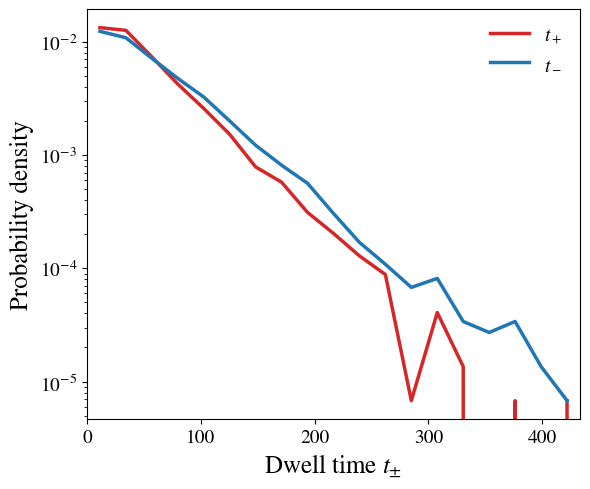

In [46]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
t_plot_max = (t_dwell_up.mean() + t_dwell_down.mean()) * 4
bins = np.linspace(0, t_plot_max, 20)
bins_center = (bins[1:] + bins[:-1]) / 2
counts_up, _ = np.histogram(t_dwell_up, bins=bins, density=True)
counts_down, _ = np.histogram(t_dwell_down, bins=bins, density=True)

ax.plot(bins_center, counts_up, "-", label="$t_+$", color="tab:red", lw=2.5)
ax.plot(bins_center, counts_down, "-", label="$t_-$", color="tab:blue", lw=2.5)
ax.set_xlim(0, t_plot_max)
ax.legend(frameon=False)
ax.set_yscale("log")
ax.set_xlabel(r"Dwell time $t_{\pm}$")
ax.set_ylabel(r"Probability density")

(0.0, 24.30148887686183)

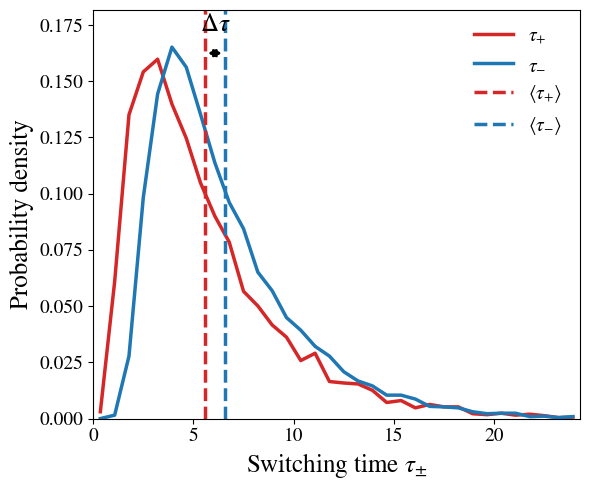

In [47]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
t_switch_up_mean, t_switch_down_mean = t_switch_up.mean(), t_switch_down.mean()
t_plot_max = (t_switch_up_mean + t_switch_down_mean) * 2

bins = np.linspace(0, t_plot_max, 35)
counts_up, _ = np.histogram(t_switch_up, bins=bins, density=True)
counts_down, _ = np.histogram(t_switch_down, bins=bins, density=True)

bins_center = (bins[1:] + bins[:-1]) / 2
ax.plot(bins_center, counts_up, "-", label=r"$\tau_{+}$", color="tab:red", lw=2.5)
ax.plot(bins_center, counts_down, "-", label=r"$\tau_{-}$", color="tab:blue", lw=2.5)
ax.axvline(
    t_switch_up_mean,
    color="tab:red",
    linestyle="--",
    lw=2.5,
    label=r"$\langle \tau_{+}\rangle$",
)
ax.axvline(
    t_switch_down_mean,
    color="tab:blue",
    linestyle="--",
    lw=2.5,
    label=r"$\langle \tau_{-}\rangle$",
)

# plot double arrow between the two lines
y_arrow = (counts_down.max() + counts_up.max()) / 2
ax.annotate(
    "",
    xy=(np.mean(t_switch_up.mean()), y_arrow),
    xytext=(np.mean(t_switch_down.mean()), y_arrow),
    arrowprops=dict(arrowstyle="<->", color="k", lw=2),
)
ax.text(
    (t_switch_up_mean + t_switch_down_mean) / 2,
    y_arrow + 0.01,
    r"$\Delta\tau$",
    ha="center",
    fontsize=18,
)

ax.legend(frameon=False)
ax.set_ylim(0, max(counts_up.max(), counts_down.max()) * 1.1)
ax.set_xlabel(r"Switching time $\tau_{\pm}$", fontsize=18)
ax.set_ylabel(r"Probability density", fontsize=18)
ax.set_xlim(bins[0], bins[-1])

## Plot sample trajectories for visualization

In [48]:
def generate_trajectory(
    max_steps,
    k1,
    k2,
    k3,
    kn1,
    kn2,
    kn3,
    J,
    N,
    init_state=(np.array(onp.random.choice([-1, 0, 1], size=(N, N))), 0),
):
    r1, r2 = onp.random.rand(max_steps), onp.random.rand(max_steps)
    r1, r2 = np.array(r1), np.array(r2)

    def step_fn(carry, i):
        a, t = carry
        a, dt = ising.KMC_step(a, J, k1, k2, k3, kn1, kn2, kn3, N, r1=r1[i], r2=r2[i])
        t += dt
        return (a, t), (t, a.mean())

    final_state, (t_trace, m_trace) = lax.scan(
        step_fn, init_state, np.arange(max_steps)
    )
    return final_state, t_trace, m_trace

In [49]:
transient_steps = 1000000
max_steps = 1000000

eb_list = onp.array([-0.1, 0, 0.1])
t_trace_all = []
m_trace_all = []

for eb in eb_list:
    params = {
        "k1": k1star * onp.exp(-eb),
        "k2": k2,
        "k3": k3,
        "kn1": k1star * epsilon * onp.exp(-eb),
        "kn2": k2 * epsilon,
        "kn3": k3 * epsilon,
        "J": J,
        "N": N,
    }
    thermal_state, _, _ = generate_trajectory(transient_steps, **params)
    final_state, t_trace, m_trace = generate_trajectory(
        max_steps, **params, init_state=(thermal_state[0], 0)
    )
    t_trace_all.append(t_trace)
    m_trace_all.append(m_trace)

(0.0, 1000.0)

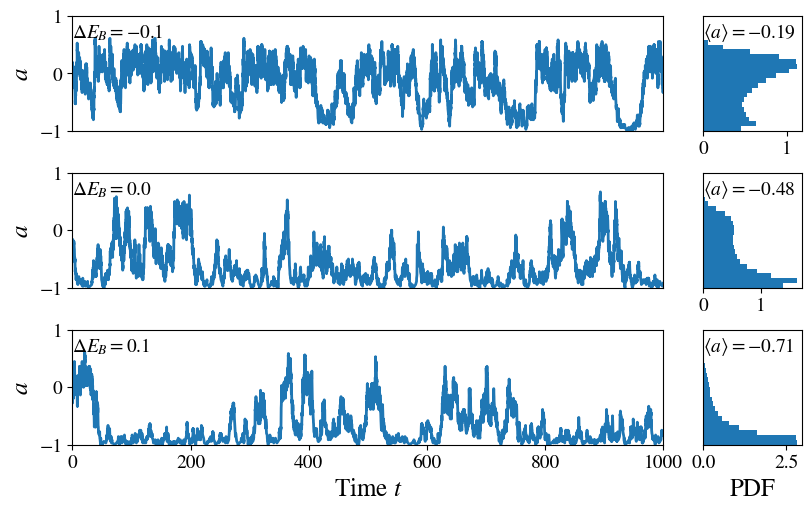

In [50]:
fig = plt.figure(figsize=(8, 5), constrained_layout=True)
max_time_plot = 800
gs = fig.add_gridspec(3, 2, width_ratios=(6, 1), wspace=0.01, hspace=0.01)

for i in range(3):
    if i == 0:
        ax1 = fig.add_subplot(gs[i, 0])
    else:
        ax1 = fig.add_subplot(gs[i, 0], sharex=ax1)
    ax2 = fig.add_subplot(gs[i, 1], sharey=ax1)
    ax1.plot(t_trace_all[i], m_trace_all[i], lw=2)

    m_hist, m_bins = np.histogram(
        m_trace_all[i][1:],
        weights=np.diff(t_trace_all[i]),
        bins=onp.linspace(-1, 1, 25),
        density=True,
    )
    ax2.stairs(m_hist, m_bins, fill=True, orientation="horizontal")

    # remove the only the y axis of the second plot
    ax2.yaxis.set_visible(False)
    ax1.xaxis.set_visible(False)
    ax1.set_ylabel(r"$a$")
    ax1.set_ylim(-1, 1)

    # add text: field
    ax1.text(
        0,
        0.81,
        r"$\Delta E_B=$" + f"${eb_list[i]:.1f}$",
        transform=ax1.transAxes,
        fontsize=14,
    )

    # add text: average activity
    a_mean = np.sum(m_trace_all[i][1:] * np.diff(t_trace_all[i])) / t_trace_all[i][-1]
    ax2.text(
        0,
        0.81,
        r"$\langle a \rangle=$" + f"${a_mean:.2f}$",
        transform=ax2.transAxes,
        fontsize=14,
    )

ax1.xaxis.set_visible(True)
ax1.set_xlabel(r"Time $t$")
ax2.set_xlabel(r"PDF")
ax1.set_xlim(0, max_time_plot)